# IN3063 Group 2 Coursework Task 1

# Table of Contents

1. [Imports](#Imports:) 
2. [Dataset Selection and description](#a-dataset-selection-and-description)
3. [Implement sigmoid and ReLU layers](#b-implement-sigmoid-and-relu-layers)
4. [Implement dropout](#d-implement-dropout)
5. [Implement a fully parameterizable neural network class](#e-implement-a-fully-parametrizable-neural-network-class)
6. [Implement optimizer](#f-implement-optimizer)
7. [Evaluate different neural network architectures/parameters present and discuss your results](#g-evaluate-different-neural-network-architecturesparameters-present-and-discuss-your-results)
8. [Code quality and report and presentation](#h-code-quality-and-report-presentation)

## a) Dataset selection and description

Label: 5


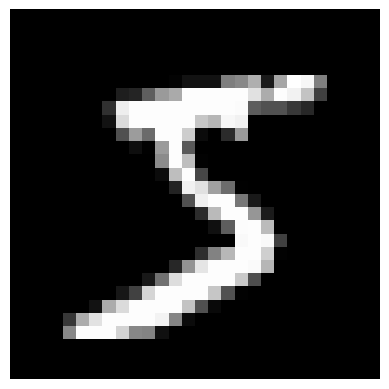

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())

image, label = mnist_dataset[0]
print("Label:" , label)

plt.imshow(image.squeeze(), cmap="gray")
plt.axis("off") 
plt.show()

## b) Implement sigmoid and ReLU layers

In [6]:
import numpy as np

class SigmoidLayer:
    def __init__(self):
        self.activation_output = None
    
    def forward_pass(self, x):
        self.activation_output = 1 / (1 + np.exp(-x))
        return self.activation_output
    
    def back_pass(self, upstream_gradient):
        return (1 - self.activation_output) * self.activation_output * upstream_gradient #return the local gradient 
    

class ReLULayer:
    def __init__(self):
        self.output = None

    def forward_pass(self, x):
        self.output = np.maximum(0, x) #relu is like _/ so max of zero and x 
        return self.output

    def back_pass(self, grad_output):
        return grad_output * np.where(self.output > 0, 1, 0)

## c) Implement softmax layer

The goal of the softmax layer is to convert raw scores (logits) from the neural network into probabilites that sum to 1.

Here is the softmax formula: $ f(z)_i = \frac{(e^z)_i}{\Sigma_j^K(e^z)_j} $

In [8]:
import numpy as np

class SoftmaxLayer:
    def __init__(self):
        self.output = None
        self.input = None
        self.dinputs = None

    def forward_pass(self, inputs):
        self.input = inputs
        inputs_stable = inputs - np.max(inputs, axis=1, keepdims=True) # stabalize inputs as exponentials grow very large or very small (numerical overflow/underflow)
        exp_values = np.exp(inputs_stable)
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.output
    
    def backward_pass(self, dvalues, true_labels):
        samples = dvalues.shape[0] # batch size
        self.dinputs = (self.output - true_labels) / samples
        return self.dinputs

## d) Implement dropout

The goal of the dropout layer is to improve the model's generalization and reduce overfitting by randomly temporarily disabling a fraction of the neurons during training, to prevent the model over-relying on specific neurons

In [9]:
import numpy as np

class DropoutLayer:
    def __init__(self, rate):
        self.rate = rate
        self.mask = None

    def forward_pass(self, inputs, training=True):
        if training:
            self.mask = (np.random.rand(*inputs.shape) > self.rate) / (1 - self.rate)
            return inputs * self.mask
        else:
            return inputs
    
    def backward_pass(self, dvalues):
        return dvalues * self.mask

## e) Implement a fully parametrizable neural network class

Feedforward neural network
You should implement a fully-connected NN class where with number of hidden
layers, units, activation functions can be changed. In addition, you can add dropout or
regularizer (L1 or L2). 


Report the parameters used (update rule, learning rate, decay,
epochs, batch size) and include the plots in your report.

In [ ]:
import numpy as np
from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    #Truncated distribution with a specified mean, standard diviation, and bounds

class NeuraNetwork:
    
     def __init__(self, in_nodes, out_nodes, hidden_nodes, units, active_func, dropoutRate=0.0, learning_rate=0.01):
        # Intialises the neural network 
        # Parameters:
        # - inNodes: number of in nodes
        # - outNode: number of out nodes                                                   
        # - hiddenNodes: number of hidden nodes
        # - units: represents the number of neurons in a layer
        # - active_func: the activation function
        # - dropout: dropout rate to reduce overfitting

        self.in_nodes=in_nodes
        self.out_nodes=out_nodes
        self.hidden_nodes=hidden_nodes
        self.units=units
        self.active_func=active_func
        self.dropout=dropoutRate
        self.learning_rate = learning_rate

        self.create_weight_matrices()

     def create_weight_matrices(self):
        """ A method to initialize the weight matrices of the neural network"""
        rad = 1 / np.sqrt(self.in_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_in_hidden = X.rvs((self.hidden_nodes, 
                                       self.in_nodes))
         
        rad = 1 / np.sqrt(self.hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_out = X.rvs((self.out_nodes, 
                                        self.hidden_nodes))


     def train(self, input_vector, target_vector,epochs=100):
        # input_vector and target_vector can be tuple, list or ndarray
        
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T
    
        for i in range(epochs):
        
            output_vector1 = np.dot(self.weights_in_hidden, input_vector)
            output_vector_hidden = self.active_func.forward_pass(output_vector1)

            output_vector2 = np.dot(self.weights_hidden_out, output_vector_hidden)
            output_vector_network = self.active_func.forward_pass(output_vector2)
            
            
            output_errors = (target_vector - output_vector_network) 
            # calculate the weight updates:
            derivative_output = self.active_func.back_pass(output_vector_network)  
            tmp = output_errors * derivative_output     
            who_update = self.learning_rate * np.dot(tmp, output_vector_hidden.T)

            # calculate hidden errors:
            hidden_errors = np.dot(self.weights_hidden_out.T, output_errors * derivative_output )

            derivative_output = self.active_func.back_pass(output_vector_hidden)   
            tmp = hidden_errors * derivative_output
            wih_update = self.learning_rate * np.dot(tmp, input_vector.T)

            # update the weights:
            self.weights_in_hidden += wih_update
            self.weights_hidden_out += who_update

            
     def run(self, input_vector):
            # input_vector can be tuple, list or ndarray
            input_vector = np.array(input_vector, ndmin=2).T
            output_vector = np.dot(self.weights_in_hidden, input_vector)
            output_vector = self.active_func.forward_pass(output_vector)
            output_vector = np.dot(self.weights_hidden_out, output_vector)
            output_vector = self.active_func.forward_pass(output_vector)
            
            return output_vector.T

Output after training: [[0.40900007]]


#### testing it out 

In [14]:

sigmoid = SigmoidLayer()
dropout = DropoutLayer(0.0)

nn = NeuraNetwork(
    in_nodes=3,       
    out_nodes=1,      
    hidden_nodes=4,   
    units=4,          
    active_func=sigmoid, 
    learning_rate=0.1
)


input_vector = [0.5, 0.2, -0.1]   
target_vector = [0.4]             

nn.train(input_vector, target_vector, epochs=1000)

output = nn.run(input_vector)
print("output after training:", output)

output after training: [[0.41101859]]


## f) Implement optimizer

## g) Evaluate different neural network architectures/parameters, present and discuss your results. 

## h) Code quality and report presentation 